# Dane
- `CPMEURNSAB1GQSK` - PKB Słowacji - dane kwartalne
- `M,NR,CDD,SK` - Liczba dni chłodniczych na Słowacji - dane miesięczne
- `M,NR,HDD,SK` - Liczba dni grzewczych na Słowacji - dane miesięczne
- `MCOILBRENTEU` - cena ropy Brent - dane miesięczne
- `POILDUBUSDM` - cena ropy Dubaj - dane miesięcnze
- `Value` - Procentowa zmiana dochodu rozporządzalnego na Słowacji - dane roczne
- `S,6000,4161901,KWH,I_TAX,EUR,SK` - cena prądu dla gospodarstw domowych na Słowacji (uwzględniając podatki) - dane semestralne
- `S,6000,4162901,KWH,I_TAX,EUR,SK` - cena prądu dla przedsiębiorców na Słowacji (uwzględniając podatki) - dane semestralne
- `S,4100,4141901,KWH,I_TAX,EUR,SK` - cena gazu dla gospodarstw domowych na Słowacji (uwzględniając podatki) - dane semestralne
- `S,4100,4141901,KWH,I_TAX,EUR,SK` - cena gazu dla przedsiębiorców na Słowacji (uwzględniając podatki) - dane semestralne

In [1]:
# przygotowanie bibliotek
import numpy as np
import scipy as sp
import statsmodels.api as sm
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import os
from pprint import pprint
from math import sqrt
import networkx as nx
matplotlib.rcParams['figure.figsize'] = [10, 10]

In [2]:
# wczytanie danych oraz oddzielenie zmiennej objaśnianej
data = pd.read_csv("./data/combined.csv")
y = data.iloc[:,7].to_frame()
data.drop("electricity_hh", axis = 1, inplace=True)
data.drop("date", axis = 1, inplace=True)

In [3]:
# ustawienie parametrów rozkładów
alpha = 0.05
T = stats.t.ppf(0.95, 29)
n = len(data)

## Wykluczanie quasi-stałych

In [4]:
Vs = dict()
for col in data.iloc[:,0:]:
    Vs[col] = np.sqrt(np.sum((data[col]-np.mean(data[col]))**2)/n)/np.mean(data[col])
pprint(Vs)

{'brent': 0.34443274929582984,
 'cooling': 1.7739231518151484,
 'disp_income': 1.205928874717976,
 'dubai': 0.33900709107070914,
 'electricity_nhh': 0.08115146912112686,
 'gas_hh': 0.08741064036365004,
 'gas_nhh': 0.11134188473644703,
 'gdp': 0.13752587878688746,
 'heating': 0.7480586481402434}


In [5]:
data.drop([k for k, v in Vs.items() if v < 0.15], axis = 1, inplace = True)
data

,cooling,heating,brent,dubai,disp_income
0,49.39,165.71,74.953333,69.972914,9.605845
1,0.00,1370.30,88.560000,83.273788,9.605845
2,0.00,1420.97,96.936667,91.109503,6.630723
3,4.26,361.62,121.396667,116.668297,6.630723
4,11.28,162.79,114.396667,113.468427,6.630723
5,0.00,1099.30,54.660000,53.603920,6.630723
6,0.00,1613.69,44.433333,44.439939,1.611855
7,0.64,304.47,58.696667,58.954935,1.611855
8,22.50,48.02,68.200000,68.067344,1.611855
9,0.00,1216.38,74.630000,75.455738,1.611855


## Obliczanie korelacji

In [6]:
data_with_y = data.copy()
data_with_y['electricity_hh'] = y.values

In [7]:
corr_mat = data_with_y.corr()
R_v = corr_mat.iloc[:-1, -1]
R_mat = corr_mat.iloc[:-1, :-1]

In [8]:
R_v

cooling        0.101051
heating       -0.029995
brent          0.112286
dubai          0.126314
disp_income   -0.437920
Name: electricity_hh, dtype: float64

In [9]:
R_mat

,cooling,heating,brent,dubai,disp_income
cooling,1.000000,-0.617967,-0.011870,-0.014305,0.087528
heating,-0.617967,1.000000,-0.047803,-0.051641,-0.028813
brent,-0.011870,-0.047803,1.000000,0.998284,-0.291639
dubai,-0.014305,-0.051641,0.998284,1.000000,-0.301521
disp_income,0.087528,-0.028813,-0.291639,-0.301521,1.000000


In [10]:
r_min = sqrt(T*T/(T*T+n-2))
print(f"{r_min = }")
R_mat[abs(R_mat) < r_min] = 0
R_mat

r_min = 0.22934589529138683


,cooling,heating,brent,dubai,disp_income
cooling,1.000000,-0.617967,0.000000,0.000000,0.000000
heating,-0.617967,1.000000,0.000000,0.000000,0.000000
brent,0.000000,0.000000,1.000000,0.998284,-0.291639
dubai,0.000000,0.000000,0.998284,1.000000,-0.301521
disp_income,0.000000,0.000000,-0.291639,-0.301521,1.000000


# Dobór zmiennych

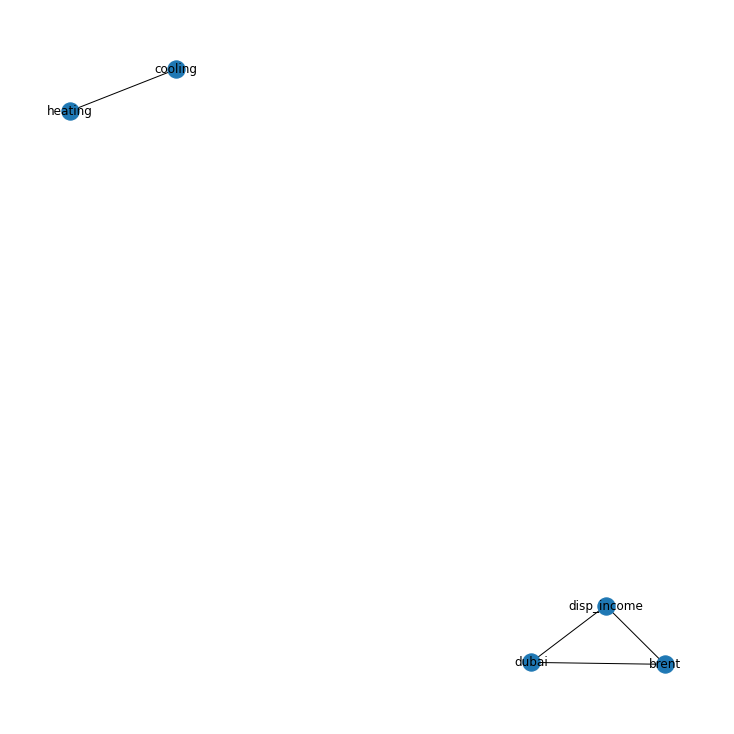

In [11]:
adj_mat = R_mat.copy()
adj_mat[adj_mat != 0] = 1
adj_mat = adj_mat.to_numpy()
for i in range(adj_mat.shape[0]):
    adj_mat[i, i] = 0

G = nx.Graph(adj_mat)
pos=nx.spring_layout(G)
nx.draw(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos, labels = dict(zip(range(len(R_mat.columns)), list(R_mat.columns))))
plt.show()

Należy wybrać dwie zmienne (delikatnie zmienione przez późniejsze testy):
1. `heating`
2. `brent`

In [12]:
#data["heating2"] = data["heating"] ** 2
data_final = data[["brent", "heating"]].to_numpy()
reg = sm.OLS(y, data_final).fit()


In [13]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         electricity_hh   R-squared (uncentered):                   0.914
Model:                            OLS   Adj. R-squared (uncentered):              0.910
Method:                 Least Squares   F-statistic:                              275.5
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                    2.13e-28
Time:                        12:34:52   Log-Likelihood:                          65.613
No. Observations:                  54   AIC:                                     -127.2
Df Residuals:                      52   BIC:                                     -123.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0024      0.000     12.907      0.000       0.002       0.003
x2          5.177e-05   1.54e-05      3.365      0.001    2.09e-05    8.26e-05
==============================================================================
Omnibus:                        2.337   Durbin-Watson:                   0.459
Prob(Omnibus):                  0.311   Jarque-Bera (JB):                1.398
Skew:                           0.027   Prob(JB):                        0.497
Kurtosis:                       2.214   Cond. No.                         18.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

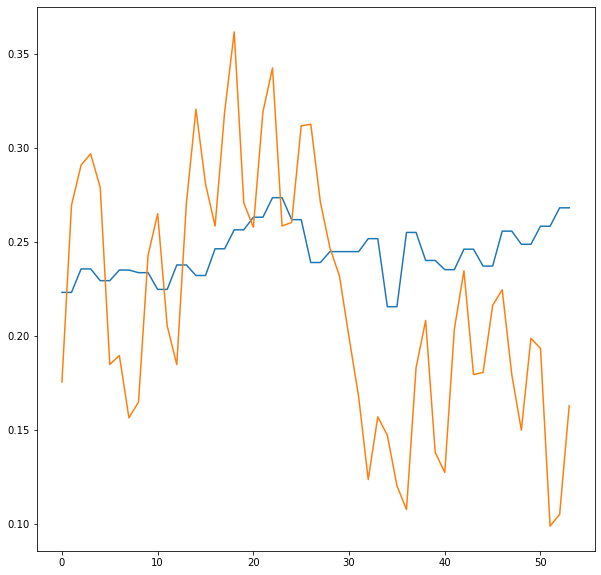

In [14]:
plt.plot(y)
plt.plot(reg.predict(data[["dubai", "heating"]].to_numpy()))
plt.show()